### Effective Key Transition : Analysis 1

- key position adjusted in increments of 0.25 mm
- vernier scale and Helmholtz resonance analysis used for effective opening / closing calibration
- key manipulated by mechanical device with **point imact** finger
- infrared sensor (IR LED + Photoreceptive Transistor) calibrated for key positions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import audacity
import TransferFunctions as tf
import SoundUtils as sut
import scipy.signal as sig
import peakutils

%matplotlib notebook

In [21]:
runnames = np.arange(250, 675, 25)
runs = 17

dfiles = []
for acq in range(3):
    dfiles.append([])
    for r, rn in enumerate(runnames):
        if acq < 3:
            acqfiles = "DATA/MAIN_4500rpm/transferfunc/%d_%d.aup" % (rn, acq)
            dfiles[acq].append(acqfiles)
        elif acq == 3:
            acqfiles = "DATA/transferfunct/b-foot/2301_closing_%d.aup" % r
            dfiles[acq].append(acqfiles)
        elif acq == 4:
            acqfiles = "DATA/transferfunct/b-foot/2301-2_closing_%d.aup" % r
            dfiles[acq].append(acqfiles)
        
reffile = "DATA/MAIN_4500rpm/transferfunc/reference_sinebbd.aup"
reffile2 = "DATA/transferfunct/b-foot/2tieclip_reference_sines.aup"

In [8]:
dfiles

[['DATA/MAIN_4500rpm/transferfunc/250_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/275_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/300_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/325_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/350_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/375_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/400_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/425_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/450_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/475_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/500_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/525_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/550_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/575_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/600_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/625_0.aup',
  'DATA/MAIN_4500rpm/transferfunc/650_0.aup'],
 ['DATA/MAIN_4500rpm/transferfunc/250_1.aup',
  'DATA/MAIN_4500rpm/transferfunc/275_1.aup',
  'DATA/MAIN_4500rpm/transferfunc/300_1.aup',
  'DATA/MAIN_4500rpm/transferfunc/325_1.aup',
  'DATA/MAIN_4500rpm/transferfunc

In [9]:
gamma=1.4
P_a=101000
rho_a=1.22
c = 343

chimney=0.0139
bore=0.0186
foot=0.16

V=(np.pi*bore**2/4)*foot
const = c**2/(4*np.pi**2*V)

In [10]:
def effective_transition(aupfile, freqIR, nfft, ch_noise=0, ch_IR=1, ch_ext=2, ch_int=3):
    '''
    Main routine for Effective Key Transition analysis.
    Uses transfer function analysis to determine when
    effective key state changes from open to closed.
    
    Input
    -----
    aupfile : audacity project file
    ch_noise, ch_IR, ch_int, ch_ext : (optional) channel numbers
        for noise, infrared, internal mic and external mic tracks
    IRfreq : frequency of infrared signal modulation
    nfft : window length for transfer function calculation
    
    Output
    ------
    returns a dictionary of the data with the following keys:
    'tf' = transfer function (internal/external response)
    'coh' = coherence (internal vs external)
    'int_mic' = internal response
    'ext_mic' = external responce
    '''    
    auf = audacity.Aup(aupfile)
    print(aupfile)
    sr = auf.rate
    rawdata = []
    maxlen = 0
    for chno in range(auf.nchannels):
        rawdata.append(auf.get_channel_data(chno))
        maxlen = max(maxlen, len(rawdata[-1]))

    data = np.zeros((len(rawdata), maxlen))
    for chno, chdata in enumerate(rawdata):
        data[chno,:len(chdata)] = chdata
        
    src = data[ch_noise,:]
    int_ = data[ch_int,:]
    ext_ = data[ch_ext,:]
    IR = data[ch_IR,:]
    
    delay = tf.determineDelay(
        src/np.mean(src),ext_/np.mean(ext_),maxdel=2**15)
    print("Delay: %d samples"%delay)
    src = np.roll(src, delay)
    
    tfxy,ff = tf.tfe(int_,ext_,Fs=sr,NFFT=nfft)
    ff,coh = sig.coherence(int_,ext_,fs=sr,nperseg=nfft)
    datadict = {'tf':tfxy,'coh':coh}
    
    for chname, chdata in zip(['int_', 'ext_'], [int_, ext_]):
        tfxy,ff = tf.tfe(chdata,src,Fs=sr,NFFT=nfft)
        datadict['%smic'%chname] = tfxy
        datadict['%sff'%chname] = ff
        
    datadict['ir_RMS'] = np.sqrt(np.mean((IR-np.mean(IR))**2))
    return datadict

In [37]:
freqIR = 9820
nfft = 1024*2

refresult = effective_transition(reffile, freqIR, nfft)

DATA/MAIN_4500rpm/transferfunc/reference_sinebbd.aup
Delay: 1765 samples


In [12]:
results = []
for acqno, acqfiles in enumerate(dfiles):
    results.append([])
    for file in acqfiles:
        filedata = effective_transition(file, freqIR, nfft)
        results[acqno].append(filedata)

DATA/MAIN_4500rpm/transferfunc/250_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/275_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/300_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/325_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/350_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/375_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/400_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/425_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/450_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/475_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/500_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/525_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/550_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/575_0.aup
Delay: 1764 samples
DATA/MAIN_4500rpm/transferfunc/600_0.aup
Delay: 1765 samples
DATA/MAIN_4500rpm/transferfunc/625_0.aup
Delay: 1765 samples
DATA/MAIN_4500rpm/transf

<IPython.core.display.Javascript object>


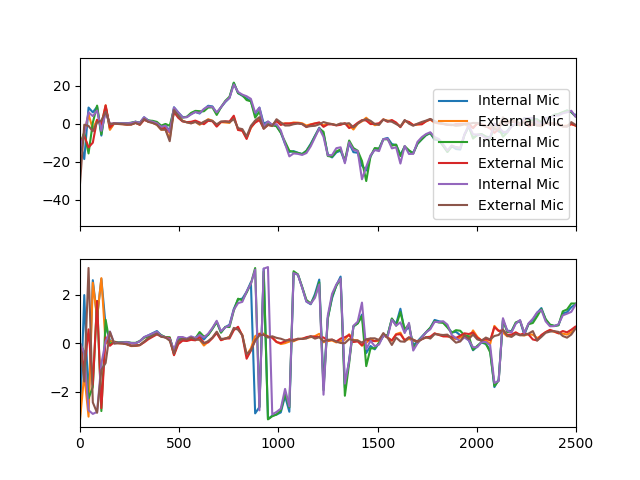

In [38]:
fig,ax = plt.subplots(2,sharex=True)

fig.set_label("Initial position (open) recordings, internal vs external spectra")

for acq, acqresults in enumerate(results):
    spectr_int = 20*np.log10(np.abs(acqresults[0]['int_mic']/refresult['int_mic']))
    angle_int = np.angle(acqresults[0]['int_mic']/refresult['int_mic'])
    ax[0].plot(refresult['int_ff'], spectr_int, label="Internal Mic")
    ax[1].plot(refresult['int_ff'], angle_int)
    
    spectr_ext = 20*np.log10(np.abs(acqresults[0]['ext_mic']/refresult['ext_mic']))
    angle_ext = np.angle(acqresults[0]['ext_mic']/refresult['ext_mic'])
    ax[0].plot(refresult['ext_ff'], spectr_ext, label="External Mic")
    ax[1].plot(refresult['ext_ff'], angle_ext)

    ax[0].legend(loc='lower right')
    ax[0].set_xlim((0, 2500))

<IPython.core.display.Javascript object>


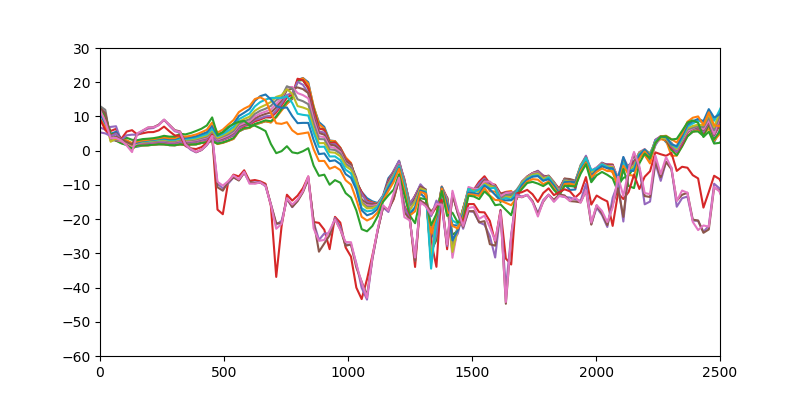

<IPython.core.display.Javascript object>


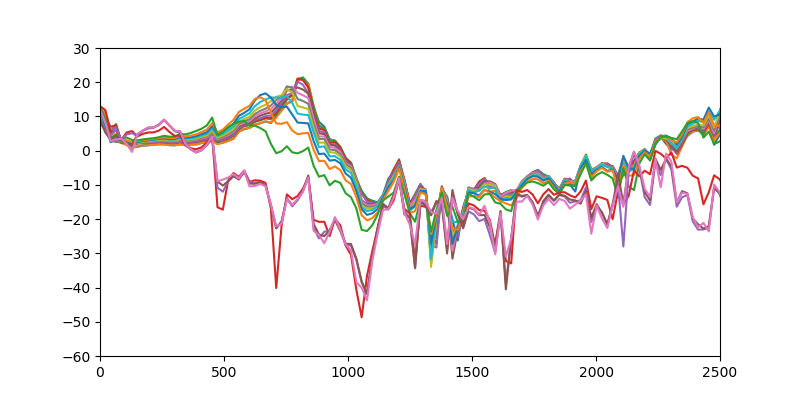

<IPython.core.display.Javascript object>


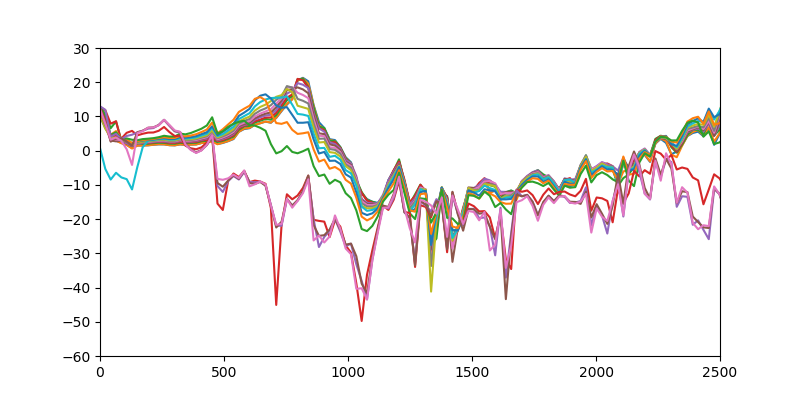

In [39]:
Hfy = []
Hfx = []
for acqno, acqresults in enumerate(results):
    Hfx.append([])
    Hfy.append([])
#     fig,ax = plt.subplots(3,sharex=True, figsize=((8,8)))
    plt.figure(figsize=(8,4))
    fig.set_label("Transfer functions, acquisition %d" % (acqno+1))
    
    for r in range(runs):
        ff = acqresults[r]['ext_ff']
        Hfreq = peakutils.indexes(
            (20*np.log10(np.abs(acqresults[r]['tf'])))[:100], thres=0.7, min_dist=1000)
        Hfx[acqno].extend(ff[Hfreq])
        Hfy[acqno].extend((20*np.log10(np.abs(acqresults[r]['tf'])))[Hfreq])
        
        plt.plot(ff, 20*np.log10(np.abs(acqresults[r]['tf'])), label="recording %d" % r)
#         ax[0].scatter(Hfx[acqno][r], Hfy[acqno][r])
        plt.xlim((0, 2500))
        plt.ylim((-60, 30))
#         ax[0].legend(loc='lower right', ncol=2)
        
#         ax[1].plot(ff,(np.angle(acqresults[r]['tf'])))
#         ax[2].scatter(ff[Hfreq], r, marker='x')
#         ax[2].plot(ff, acqresults[r]['coh'])

In [36]:
keytrans = []
for acqno, acqresults in enumerate(results):
    Hff = Hfx[acqno]
    openHf = max(Hff)
    closedHf = min(Hff)
    ktrans = ()
    for r in range(runs):
        if Hff[r]==openHf and Hff[r+1]!=openHf:
            ktrans = ktrans+(r,)
        elif Hff[r]==closedHf:
            ktrans = ktrans+(r,)
            break
    keytrans.append(ktrans)
    
keytrans

[(2, 13), (2, 13), (2, 13)]

<IPython.core.display.Javascript object>


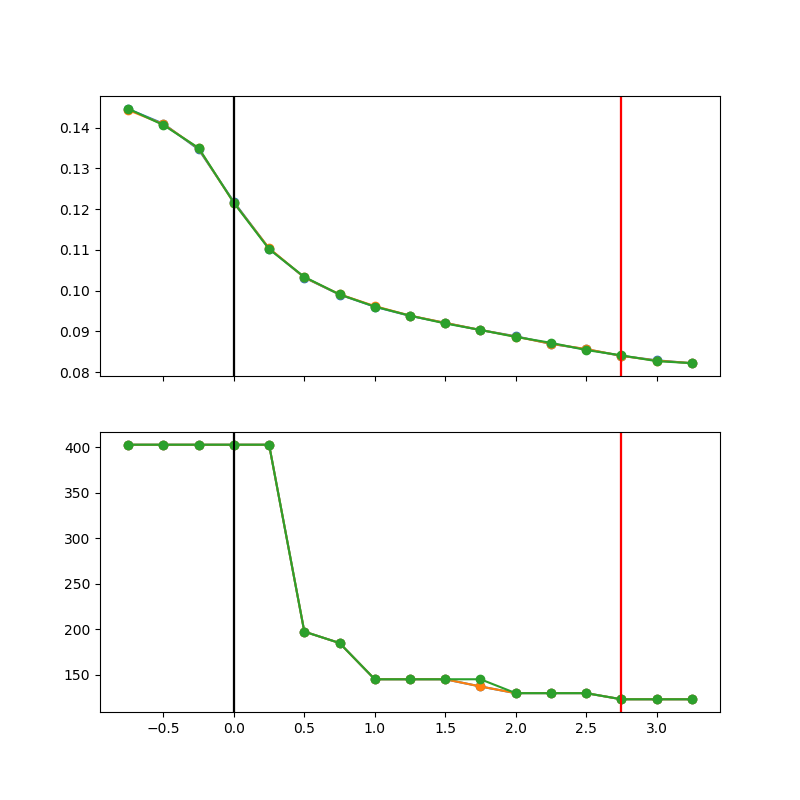

In [40]:
fig,ax = plt.subplots(2,sharex=True, figsize=(8,8))
fig.set_label('')

keyincrs = []
areaincrs = []
effLincrs = []
inertvals = []
for acqno, (acqresults, ktrans) in enumerate(zip(results, keytrans)):
    keyvals = np.arange(runs)
    keyincr = [(k-ktrans[1])*(-0.25) for k in keyvals]
    keyincrs.append(keyincr)
    ax[0].plot(keyincr, [result['ir_RMS'] for result in acqresults], 'o-')
    ax[0].axvline(keyincr[ktrans[0]], color='r')
    ax[0].axvline(keyincr[ktrans[1]], color='k')
    areaincr = [np.pi*chimney*1000*incr*2/3 for incr in keyincr]
    areaincrs.append(areaincr)
    areaincrSI = [np.pi*chimney*incr*2/3000 for incr in keyincr]
    inert = [gamma*P_a/(4*np.pi**2*f**2*V) for f in Hfx[acqno]]
    inert[ktrans[1]:] = [inert[ktrans[1]-1] for i in range(len(inert[ktrans[1]:]))]
    inertvals.append(inert)
    effL = [inert[i]*areaincrSI[i]/rho_a for i in range(runs)]
    effL[effL.index(0.0):] = [np.nan for i in range(runs-effL.index(0.0))]
    effLincrs.append(effL)
    ax[1].plot(keyincr, inert, 'o-')
    ax[1].axvline(keyincr[ktrans[0]], color='r')
    ax[1].axvline(keyincr[ktrans[1]], color='k')

In [18]:
# Results averaged from all acquisitions and exported to csv

HFreq = []
KPos = []
AFlow = []
LEnd = []
Inert = []

for acqno, acqresults in enumerate(results):
    HFreq.append(Hfx[acqno])
    KPos.append(keyincr)
    AFlow.append(areaincrs[acqno])
    LEnd.append(effLincrs[acqno])
    Inert.append(inertvals[acqno])
    
    
HFreq = np.mean(tuple(HFreq), axis=0)
KPos = np.mean(tuple(KPos), axis=0)
AFlow = np.mean(tuple(AFlow), axis=0)
LEnd = np.mean(tuple(LEnd), axis=0)
Inert = np.mean(tuple(Inert), axis=0)

SAVEDATA = np.append([HFreq], [KPos, AFlow, LEnd, Inert], axis=0)
np.savetxt("RESULTS/inertance_trill.csv", SAVEDATA.T, fmt=('%.2f','%.2f','%.2f','%.4f','%.2f') , delimiter=',')

In [19]:
print(SAVEDATA[4])

[  123.04655321   123.04655321   123.04655321   129.78759886   129.78759886
   129.78759886   139.74686503   145.04426354   145.04426354   145.04426354
   184.88993011   197.42135871   402.90073206  1233.88349193  1233.88349193
  1233.88349193  1233.88349193]
